In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import scprep
import numpy as np
import pickle

In [2]:
import torch
from scipy.stats import gaussian_kde
import numpy as np

def kde(data, points_to_evaluate=None, bandwidth=None):
    """
    Perform kernel density estimation on n-dimensional data.
    
    Args:
        data (np.ndarray or torch.Tensor): Input data of shape (n_samples, n_dimensions)
        points_to_evaluate (np.ndarray or torch.Tensor, optional): Points at which to evaluate the KDE. 
            If None, the original data points are used.
        bandwidth (float, optional): Bandwidth for KDE. If None, Scott's rule is used.
    
    Returns:
        np.ndarray or torch.Tensor: Estimated density at each point in points_to_evaluate
    """
    is_torch = isinstance(data, torch.Tensor)
    
    if is_torch:
        original_dtype = data.dtype
        original_device = data.device
        data_np = data.cpu().numpy()
    else:
        data_np = data
    
    kde = gaussian_kde(data_np.T, bw_method=bandwidth)
    
    if points_to_evaluate is None:
        points_to_evaluate = data_np
    elif is_torch and isinstance(points_to_evaluate, torch.Tensor):
        points_to_evaluate = points_to_evaluate.cpu().numpy()
    
    result = kde(points_to_evaluate.T)
    
    if is_torch:
        result = torch.tensor(result, dtype=original_dtype, device=original_device)
    
    return result


In [3]:
res_dir = '../results_Mar4'
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')
filtered_bc = np.load(f'{res_dir}/day0_filtered_barcodes.npy', allow_pickle=True)
adata_filtered = adata[filtered_bc,:]

In [4]:
# sc.pp.log1p(adata_filtered)

In [5]:
adata_filtered_0 = adata_filtered
adata_filtered_0 = adata_filtered_0[adata_filtered_0.obs['louvain'] == '5']

In [6]:
with open('../results_final_Dec22/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
X_phate = scaler.transform(adata.obsm['X_phate'])
traj_T = np.load('../results_final_Dec22/trajectories_T_extreme.npy')
traj_T_not_extreme = np.load('../results_final_Dec22/trajectories_T.npy')
start_pts = traj_T[0, :]
start_pts_not_extreme = traj_T_not_extreme[0, :]

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [7]:
start_pts_unscaled = scaler.inverse_transform(start_pts)
start_pts_not_extreme_unscaled = scaler.inverse_transform(start_pts_not_extreme)

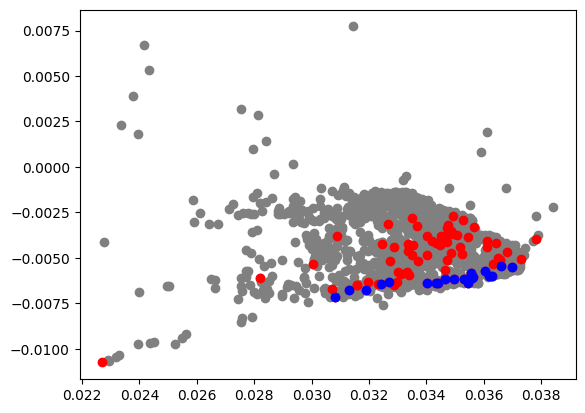

In [8]:
plt.scatter(adata_filtered_0.obsm['X_phate'][:,0], adata_filtered_0.obsm['X_phate'][:,1], color='gray')
plt.scatter(start_pts_not_extreme_unscaled[:,0], start_pts_not_extreme_unscaled[:,1], color='red')
plt.scatter(start_pts_unscaled[:,0], start_pts_unscaled[:,1], color='blue')


In [9]:
X_phate0 = scaler.transform(adata_filtered_0.obsm['X_phate'])

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/tmp/ipykernel_125465/2317810049.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_filtered_0.obs['density_start_pts'] = density_start_pts


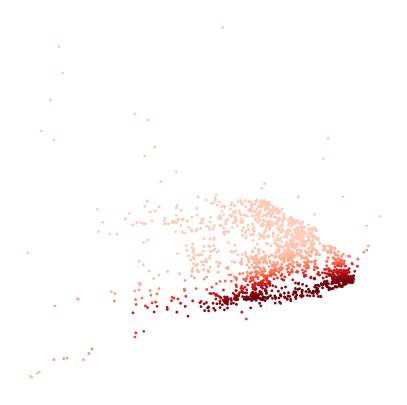

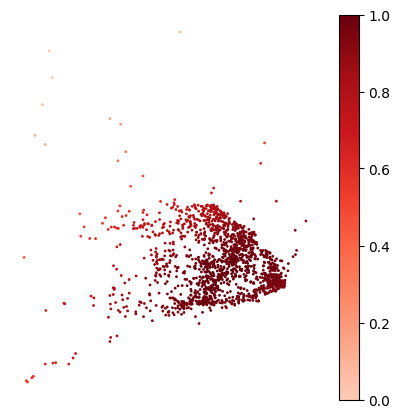

In [10]:
density_start_pts = kde(start_pts, X_phate0, bandwidth=5)
density_start_pts = (density_start_pts - density_start_pts.min()) / (density_start_pts.max() - density_start_pts.min())
density_start_pts_not_extreme = kde(start_pts_not_extreme, X_phate0, bandwidth=5)
density_start_pts_not_extreme = (density_start_pts_not_extreme - density_start_pts_not_extreme.min()) / (density_start_pts_not_extreme.max() - density_start_pts_not_extreme.min())

adata_filtered_0.obs['density_start_pts'] = density_start_pts
adata_filtered_0.obs['density_start_pts_not_extreme'] = density_start_pts_not_extreme


from matplotlib import colormaps
from matplotlib.colors import ListedColormap

cmap = colormaps['Reds']
cmap = ListedColormap(cmap(range(256)[50:]))

plt.figure(figsize=(5, 5))
scatter = plt.scatter(X_phate0[:, 0], X_phate0[:, 1], c=density_start_pts, cmap=cmap, s=1, label='Extreme')
# plt.colorbar(scatter)
plt.box(False)
plt.tick_params(left=False, bottom=False)
plt.xticks([])
plt.yticks([])
# plt.legend()
# plt.savefig(f'{res_dir}/start_pts_kde.pdf', bbox_inches='tight', transparent=True, dpi=300)
plt.show()
plt.figure(figsize=(5, 5))
scatter = plt.scatter(X_phate0[:, 0], X_phate0[:, 1], c=density_start_pts_not_extreme, cmap=cmap, s=1, label='Not Extreme')
plt.colorbar(scatter)
plt.box(False)
plt.tick_params(left=False, bottom=False)
plt.xticks([])
plt.yticks([])
# plt.legend()
# plt.savefig(f'{res_dir}/start_pts_kde_not_extreme.pdf', bbox_inches='tight', transparent=True, dpi=300)
plt.show()



<Axes: >

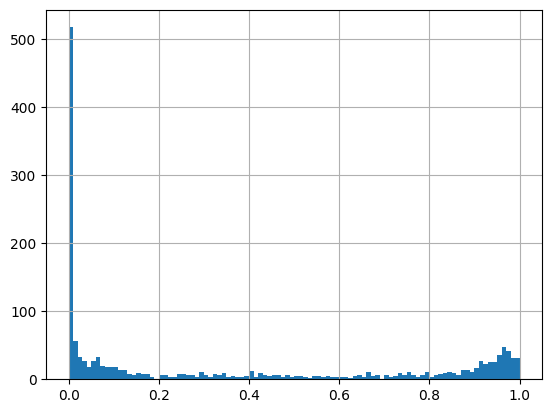

In [11]:
adata_filtered_0.obs['density_start_pts'].hist(bins=100)

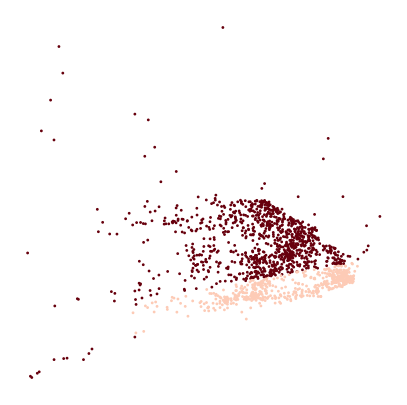

In [12]:
plt.figure(figsize=(5, 5))
scatter = plt.scatter(X_phate0[:, 0], X_phate0[:, 1], c=adata_filtered_0.obs['density_start_pts'] < 0.5, cmap=cmap, s=1, label='Extreme')
# plt.colorbar(scatter)
plt.box(False)
plt.tick_params(left=False, bottom=False)
plt.xticks([])
plt.yticks([])
# plt.legend()
# plt.savefig(f'{res_dir}/start_pts_kde.pdf', bbox_inches='tight', transparent=True, dpi=300)
plt.show()

In [13]:
import magic
magic_op = magic.MAGIC(random_state=42)
magic_op.fit(adata_filtered_0.obsm['X_pca'])

Running MAGIC on 1582 cells and 50 genes.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.76 seconds.
  Calculating affinities...
  Calculated affinities in 0.92 seconds.
Calculated graph and diffusion operator in 1.70 seconds.


MAGIC(knn_max=15, random_state=42)

In [14]:
X_magic = magic_op.transform(adata_filtered_0.to_df())

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Running MAGIC with `solver='exact'` on 21465-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
Calculating imputation...
Calculated imputation in 4.44 seconds.


In [15]:
import pandas as pd
# Calculate Pearson correlation between 'start' and each gene in X_magic using vectorized operations
start_values = adata_filtered_0.obs['density_start_pts'].values

# Compute correlations in a vectorized way
# First center the data
start_centered = start_values - start_values.mean()
X_magic_centered = X_magic - X_magic.mean()

# Compute correlation coefficients
start_std = start_centered.std()
X_magic_std = X_magic_centered.std()
correlations = (start_centered @ X_magic_centered) / (len(start_values) * start_std * X_magic_std)

# Convert to Series for easier sorting/analysis
corr_series = pd.Series(correlations, index=X_magic.columns)
print(f"Top positively correlated genes with 'start':")
print(corr_series.sort_values(ascending=False).head(10))
print("\nTop negatively correlated genes with 'start':")
print(corr_series.sort_values().head(10))

Top positively correlated genes with 'start':
UQCC3     0.863084
EMC8      0.856509
CKS1B     0.855987
POLR2K    0.855424
GTF2A2    0.853123
CENPN     0.848520
CBFB      0.843066
ALKBH3    0.842868
WRNIP1    0.842213
ITGAE     0.841649
dtype: float64

Top negatively correlated genes with 'start':
BNIP3L     -0.791964
ARPC1B     -0.768894
NEAT1      -0.765388
SLC16A4    -0.763209
ALKBH7     -0.760186
RHOQ       -0.756164
CXXC4      -0.748802
MGST3      -0.742282
WIPI1      -0.742169
C19orf66   -0.720818
dtype: float64


<Axes: >

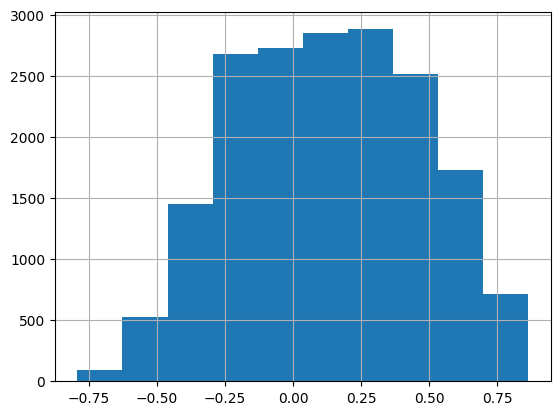

In [16]:
corr_series.hist()

In [17]:
corr_series['EPCAM']

0.4798963563688069

In [18]:
corr_series['CAV1']

0.33805133792189435